# Лінійна регресія: перенавчання та регуляризація

У цьому завданні ми на прикладах побачимо, як перенавчаються лінійні моделі, розберемо, чому так відбувається, і з'ясуємо, як діагностувати та контролювати перенавчання.

У всіх комірках, де написано коментар з інструкціями, потрібно написати код, який виконує ці інструкції. Інші комірки з кодом (без коментарів) потрібно просто виконати. Крім того, у завданні потрібно відповідати на запитання; відповіді слід вписувати після виділеного слова "Відповідь:".

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns

Ми будемо працювати з датасетом "bikes_rent.csv", в якому щодня записані календарна інформація та погодні умови, що характеризують автоматизовані пункти прокату велосипедів, а також кількість прокатів цього дня. Останнє ми передбачатимемо; таким чином, ми вирішуватимемо завдання регресії.

### Знакомство с данными

# Завдання 1

Завантажте датасет за допомогою функції pandas.read_csv у змінну df. Виведіть перші 5 рядків, щоб переконатися у коректному зчитуванні даних:

In [1]:
#Додайте код
import pandas as pd

# Завантаження датасету у змінну df
df = pd.read_csv('bikes_rent.csv')

# Виведення перших 5 рядків датасету
print(df.head())


   season  yr  mnth  holiday  weekday  workingday  weathersit       temp  \
0       1   0     1        0        6           0           2  14.110847   
1       1   0     1        0        0           0           2  14.902598   
2       1   0     1        0        1           1           1   8.050924   
3       1   0     1        0        2           1           1   8.200000   
4       1   0     1        0        3           1           1   9.305237   

      atemp      hum  windspeed(mph)  windspeed(ms)   cnt  
0  18.18125  80.5833       10.749882       4.805490   985  
1  17.68695  69.6087       16.652113       7.443949   801  
2   9.47025  43.7273       16.636703       7.437060  1349  
3  10.60610  59.0435       10.739832       4.800998  1562  
4  11.46350  43.6957       12.522300       5.597810  1600  


Для кожного дня прокату відомі такі ознаки:

* _season_: 1 - весна, 2 - літо, 3 - осінь, 4 - зима
* _yr_: 0 - 2011, 1 - 2012
* _mnth_: від 1 до 12
* _holiday_: 0 – немає свята, 1 – є свято
* _weekday_: від 0 до 6
* _workingday_: 0 - неробочий день, 1 - робочий день
* _weathersit_: оцінка сприятливості погоди від 1 (чистий, ясний день) до 4 (злива, туман)
* _temp_: температура у Цельсіях
* _atemp_: температура по відчуттям у Цельсіях
* _hum_: вологість
* _windspeed(mph)_: швидкість вітру в милях на годину
* _windspeed(ms)_: швидкість вітру в метрах за секунду
* _cnt_: кількість орендованих велосипедів (це цільова ознака, його ми передбачатимемо)

Отже, у нас є дійсні, бінарні та номінальні (порядкові) ознаки, і з усіма з них можна працювати як із речовими. З номінальними ознаками теж можна працювати як із дійсними, тому що на них заданий порядок. Давайте подивимося на графіках, як цільова ознака залежить від інших

Побудуйте графіки залежностей атрибутів від кількості подорожей. Тобто вам потрібно побудувати 12 графіків. На кожному має бути зображена залежність чергового атрибуту від змінної **cnt**.

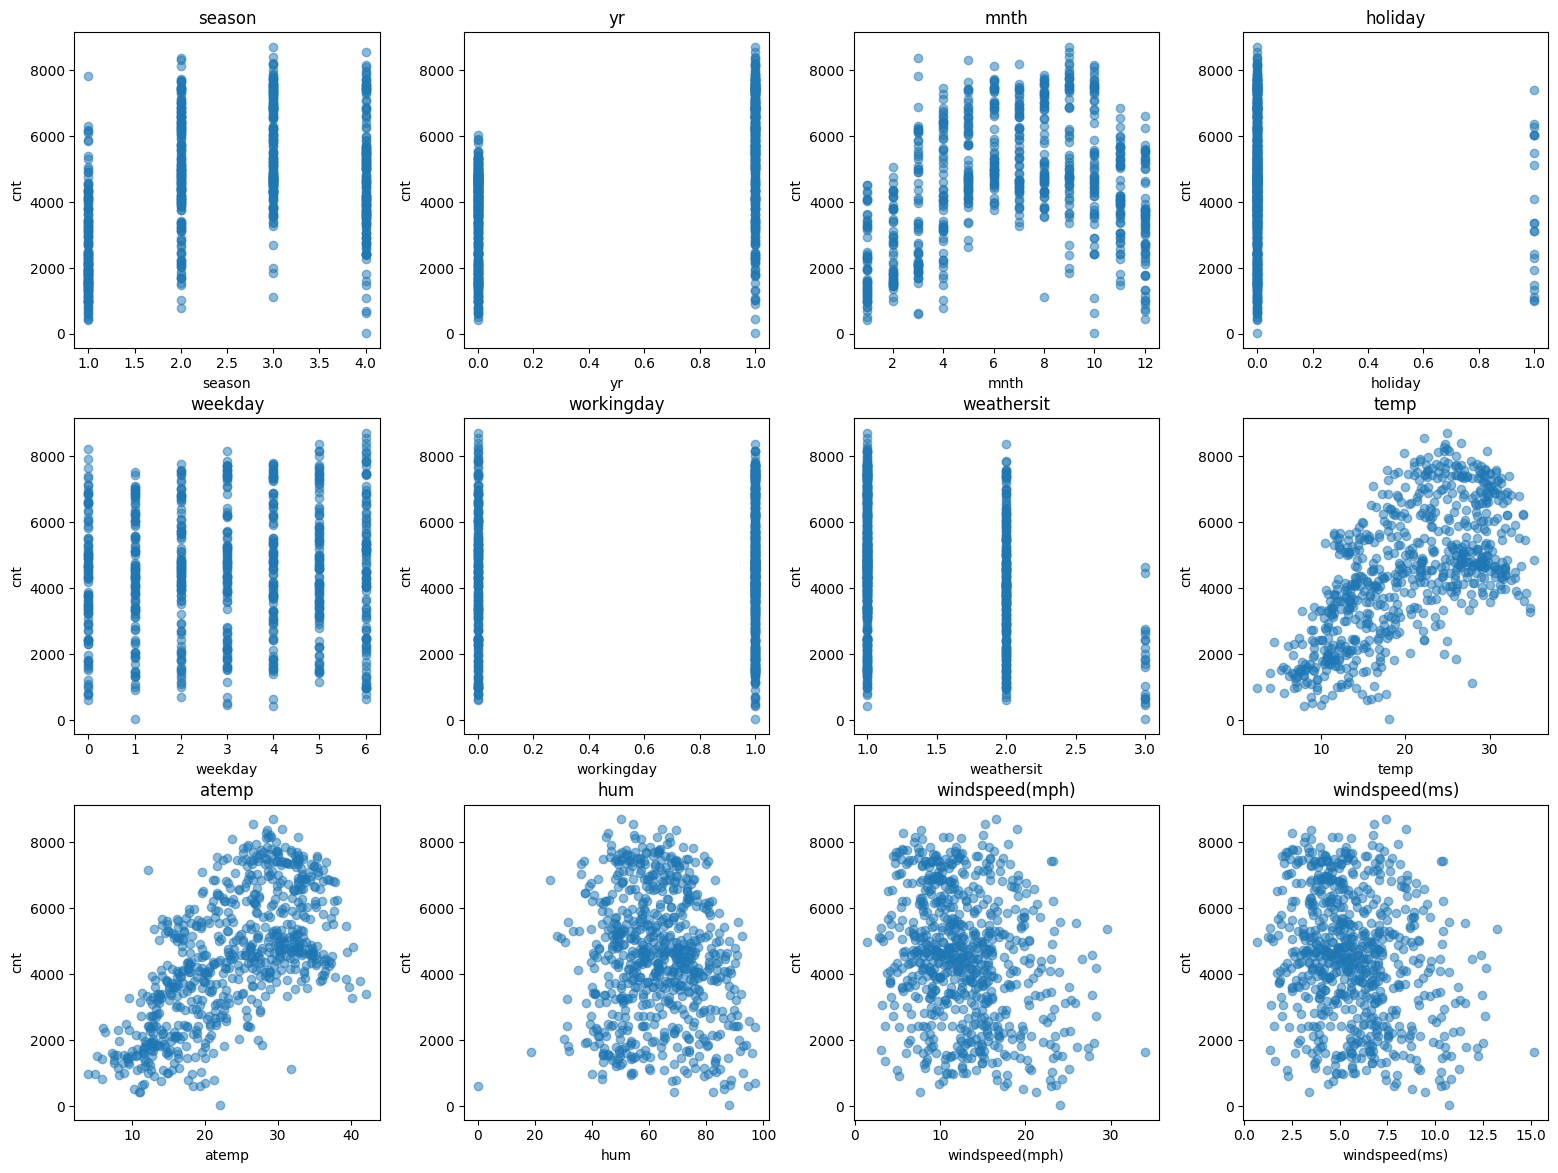

In [2]:
#Додайте код
import matplotlib.pyplot as plt

# Створюємо підграфіки для 12 графіків
fig, axes = plt.subplots(nrows=3, ncols=4, figsize=(16, 12))
fig.tight_layout(pad=3.0)  # Встановлюємо відступи між графіками

# Список назв атрибутів
attributes = ["season", "yr", "mnth", "holiday", "weekday", "workingday", "weathersit", "temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)"]

# Побудова графіків
for i, ax in enumerate(axes.flat):
    ax.scatter(df[attributes[i]], df["cnt"], alpha=0.5)
    ax.set_title(attributes[i])
    ax.set_xlabel(attributes[i])
    ax.set_ylabel("cnt")

plt.show()


Питання:
1. Який характер залежності кількості прокатів від місяця?
1. Вкажіть одну чи дві ознаки, від яких кількість прокатів швидше за все залежить лінійно


Вiдповiдь

1.Залежність кількості прокатів від місяця виглядає не зовсім лінійною. Зазвичай весна і літо мають більше прокатів в порівнянні з осінню і зимою. Однак ця залежність має неоднаковий характер: весною і літом кількість прокатів зростає, але взимку зменшується.

2.Однією з ознак, від якої кількість прокатів може залежати лінійно, є температура (temp). Якщо температура підвищується, то, як правило, збільшу


# Завдання 2

Давайте суворо оцінимо рівень лінійної залежності між ознаками та цільовою змінною. Гарною мірою лінійної залежності між двома векторами є кореляція Пірсона. Для її обчислення в pandas можна використовувати методи датафрейму: corr та corrwith.

Порахуйте кореляції всіх ознак, крім останньої, з останнім за допомогою методу `corrwith`.

In [6]:
import pandas as pd

# Завантажимо датасет із зазначенням шляху до нього
df = pd.read_csv('bikes_rent.csv')

# Виберемо ознаки, від яких можлива лінійна залежність
selected_features = ["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)"]

# Обчислимо кореляцію Пірсона між вибраними ознаками та цільовою змінною "cnt"
correlations = df[selected_features + ["cnt"]].corr()
correlation_with_cnt = correlations['cnt']

print(correlation_with_cnt)

df = pd.read_csv('bikes_rent.csv')

# Вибірка дійсних ознак для обчислення кореляцій
continuous_features = ["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)"]

# Обчислення кореляцій між дійсними ознаками
correlations_continuous = df[continuous_features].corr()

print(correlations_continuous)


temp              0.627494
atemp             0.631066
hum              -0.100659
windspeed(mph)   -0.234545
windspeed(ms)    -0.234545
cnt               1.000000
Name: cnt, dtype: float64
                    temp     atemp       hum  windspeed(mph)  windspeed(ms)
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000


У вибірці є ознаки, що корелюють із цільовим, а отже, завдання можна вирішувати лінійними методами.

По графікам видно, деякі ознаки схожі один на одного. Тому давайте також порахуємо кореляції між дійсними ознаками.

# Завдання 3

Порахуйте попарні кореляції між ознаками temp, atemp, hum, windspeed(mph), windspeed(ms) та cnt
за допомогою методу corr:

In [7]:
#Додайте код
import pandas as pd

# Завантаження датасету
df = pd.read_csv('bikes_rent.csv')

# Вибірка ознак для обчислення попарних кореляцій
selected_features = ["temp", "atemp", "hum", "windspeed(mph)", "windspeed(ms)", "cnt"]

# Обчислення попарних кореляцій
correlations = df[selected_features].corr()

# Виведення кореляцій
print(correlations)


                    temp     atemp       hum  windspeed(mph)  windspeed(ms)  \
temp            1.000000  0.991702  0.126963       -0.157944      -0.157944   
atemp           0.991702  1.000000  0.139988       -0.183643      -0.183643   
hum             0.126963  0.139988  1.000000       -0.248489      -0.248489   
windspeed(mph) -0.157944 -0.183643 -0.248489        1.000000       1.000000   
windspeed(ms)  -0.157944 -0.183643 -0.248489        1.000000       1.000000   
cnt             0.627494  0.631066 -0.100659       -0.234545      -0.234545   

                     cnt  
temp            0.627494  
atemp           0.631066  
hum            -0.100659  
windspeed(mph) -0.234545  
windspeed(ms)  -0.234545  
cnt             1.000000  


In [8]:
plt.rcParams["figure.figsize"] = (16, 10)
sns.heatmap(df.iloc[:, 7:].corr(), annot=True, cmap='icefire_r')
plt.title('Попарні кореляції між ознаками', fontsize=20, color='g')
plt.show()

NameError: name 'sns' is not defined

На діагоналях, як і належить, стоять одиниці. Однак у матриці є ще дві пари сильно корелюючих стовпців: temp і atemp (корелюють за своєю природою) і два windspeed (бо це просто переведення одних одиниць в інші). Далі ми побачимо, що цей факт негативно впливає на навчання лінійної моделі.

# Завдання 4

Виведіть середні ознаки

In [9]:
#Додайте код
import pandas as pd

# Завантаження датасету
df = pd.read_csv('bikes_rent.csv')

# Обчислення середніх значень ознак
mean_features = df.mean()

# Виведення середніх значень
print(mean_features)


season               2.496580
yr                   0.500684
mnth                 6.519836
holiday              0.028728
weekday              2.997264
workingday           0.683995
weathersit           1.395349
temp                20.310776
atemp               23.717699
hum                 62.789406
windspeed(mph)      12.762576
windspeed(ms)        5.705220
cnt               4504.348837
dtype: float64


Ознаки мають різний масштаб, отже, для подальшої роботи нам краще нормувати матрицю об'єкти-ознаки.

### Проблема перша: колінеарні ознаки

Отже, в наших даних одна ознака дублює іншу, і є ще дві дуже схожі. Звичайно, ми могли б відразу видалити дублікати, але давайте подивимося, як відбувалося б навчання моделі, якби ми не помітили цю проблему.

Для початку проведемо масштабування, або стандартизацію ознак: з кожної ознаки віднімемо його середнє і поділимо стандартне відхилення. Це можна зробити за допомогою методу scale.

Крім того, потрібно перемішати вибірку, це буде потрібно для крос-валідації.

In [10]:
from sklearn.preprocessing import scale
from sklearn.utils import shuffle

In [11]:
df_shuffled = shuffle(df, random_state=42)
X = scale(df_shuffled[df_shuffled.columns[:-1]])
y = df_shuffled["cnt"]

Давайте навчимо лінійну регресію на наших даних і подивимося на ваги ознак.

In [12]:
from sklearn.linear_model import LinearRegression

# Завдання 5

Створіть об'єкт лінійного регресора, навчіть його на всіх даних і виведіть ваги моделі (ваги зберігаються в змінній `coef_` класу регресора). Можна виводити пари (назва ознаки, вага), скориставшись функцією `zip`, вбудованою в мову python. Назви ознак зберігаються у змінній `df.columns`.

In [13]:
reg = LinearRegression().fit(X, y)
[i for i in list(zip(df.columns, reg.coef_))]

from sklearn.linear_model import LinearRegression

# Створення об'єкта лінійного регресора
regressor = LinearRegression()

# Розділення даних на ознаки і цільову змінну
X = df.drop('cnt', axis=1)
y = df['cnt']

# Навчання регресора на всіх даних
regressor.fit(X, y)

# Отримання ваг моделі
coefficients = list(zip(X.columns, regressor.coef_))

# Виведення пар (назва ознаки, вага)
for feature, weight in coefficients:
    print(f"Ознака: {feature}, Вага: {weight}")


Ознака: season, Вага: 514.2755144217309
Ознака: yr, Вага: 2043.9358557550588
Ознака: mnth, Вага: -40.96296224733487
Ознака: holiday, Вага: -519.3879461125579
Ознака: weekday, Вага: 68.49550444316866
Ознака: workingday, Вага: 121.29150193414044
Ознака: weathersit, Вага: -606.453249792301
Ознака: temp, Вага: 48.99538908049351
Ознака: atemp, Вага: 71.91493309746625
Ознака: hum, Вага: -10.23058594991835
Ознака: windspeed(mph), Вага: 2401064826724.129
Ознака: windspeed(ms), Вага: -5371182017466.677


Ми бачимо, що ваги при лінійно-залежних ознаках по модулю значно більші, ніж за інших ознак. Щоб зрозуміти, чому так сталося, згадаємо аналітичну формулу, за якою обчислюються ваги лінійної моделі у методі найменших квадратів:

$$w = (X^TX)^{-1} X^T y$$

Якщо $X$ є колінеарні (лінійно-залежні) стовпці, матриця $X^TX$ стає виродженою, і формула перестає бути коректною. Чим більш залежні ознаки, тим меншим є визначник цієї матриці і тим гірша апроксимація $Xw \approx y$. Таку ситуацію називають _проблемою мультиколлінеарності_.

З парою (temp, atemp) трохи менш корелюючих змінних такого не сталося, проте на практиці завжди варто уважно стежити за коефіцієнтами за схожих ознак.

Для того, щоб вирішити проблему мультиколінеарності, потрібно скористатися регуляризатором. До функціонала, що оптимізується, додають $L_1$ або $L_2$ норму ваг, помножену на коефіцієнт регуляризації $\alpha$. У першому випадку метод називається Lasso, а в другому --- Ridge.

# Завдання 6
Давайте спробуємо навчити лінійні моделі з L_1 і L_2-регуляризацією, а далі порівняємо їх ваги. Навчіть регресори Ridge і Lasso з параметрами за промовчанням і переконайтеся, що проблема з вагами вирішилася.

Навчіть лінійну модель з $L_1$-регуляризацією (клас Lasso) і виведіть ваги

In [14]:
from sklearn.linear_model import Lasso, Ridge


# Створення об'єкта Ridge регресора
ridge_regressor = Ridge()

# Навчання Ridge регресора
ridge_regressor.fit(X, y)

# Ваги Ridge регресора
ridge_coefficients = list(zip(X.columns, ridge_regressor.coef_))

# Виведення пар (назва ознаки, вага) для Ridge регресора
print("Ridge регресор:")
for feature, weight in ridge_coefficients:
    print(f"Ознака: {feature}, Вага: {weight}")

# Створення об'єкта Lasso регресора
lasso_regressor = Lasso()

# Навчання Lasso регресора
lasso_regressor.fit(X, y)

# Ваги Lasso регресора
lasso_coefficients = list(zip(X.columns, lasso_regressor.coef_))

# Виведення пар (назва ознаки, вага) для Lasso регресора
print("\nLasso регресор:")
for feature, weight in lasso_coefficients:
    print(f"Ознака: {feature}, Вага: {weight}")


Ridge регресор:
Ознака: season, Вага: 507.8018818505639
Ознака: yr, Вага: 2029.08905419705
Ознака: mnth, Вага: -38.47089727912119
Ознака: holiday, Вага: -493.27801548382104
Ознака: weekday, Вага: 69.11396965165959
Ознака: workingday, Вага: 121.52442502929453
Ознака: weathersit, Вага: -605.2055553731528
Ознака: temp, Вага: 49.31676759598563
Ознака: atemp, Вага: 71.78598727334753
Ознака: hum, Вага: -10.383394500484648
Ознака: windspeed(mph), Вага: -31.93550169429181
Ознака: windspeed(ms), Вага: -14.276040263826614

Lasso регресор:
Ознака: season, Вага: 506.5512786498074
Ознака: yr, Вага: 2036.2316676979037
Ознака: mnth, Вага: -38.07827028932167
Ознака: holiday, Вага: -484.65194618654056
Ознака: weekday, Вага: 68.93837479133958
Ознака: workingday, Вага: 118.4475975866837
Ознака: weathersit, Вага: -604.5667118927049
Ознака: temp, Вага: 51.363260585616366
Ознака: atemp, Вага: 69.91273749012187
Ознака: hum, Вага: -10.352705204636573
Ознака: windspeed(mph), Вага: -38.34106761310847
Ознака: wi

In [15]:
lasso = Lasso().fit(X, y)
[i for i in list(zip(df.columns, lasso.coef_))]

[('season', 506.5512786498074),
 ('yr', 2036.2316676979037),
 ('mnth', -38.07827028932167),
 ('holiday', -484.65194618654056),
 ('weekday', 68.93837479133958),
 ('workingday', 118.4475975866837),
 ('weathersit', -604.5667118927049),
 ('temp', 51.363260585616366),
 ('atemp', 69.91273749012187),
 ('hum', -10.352705204636573),
 ('windspeed(mph)', -38.34106761310847),
 ('windspeed(ms)', -0.0)]

Навчіть лінійну модель з $L_2$-регуляризацією (клас Ridge) і виведіть ваги

In [16]:
ridge = Ridge().fit(X, y)
[i for i in list(zip(df.columns, ridge.coef_))]

from sklearn.linear_model import Ridge

# Створення об'єкта Ridge регресора
ridge_regressor = Ridge()

# Навчання Ridge регресора
ridge_regressor.fit(X, y)

# Ваги Ridge регресора
ridge_coefficients = list(zip(X.columns, ridge_regressor.coef_))

# Виведення пар (назва ознаки, вага) для Ridge регресора
for feature, weight in ridge_coefficients:
    print(f"Ознака: {feature}, Вага: {weight}")


Ознака: season, Вага: 507.8018818505639
Ознака: yr, Вага: 2029.08905419705
Ознака: mnth, Вага: -38.47089727912119
Ознака: holiday, Вага: -493.27801548382104
Ознака: weekday, Вага: 69.11396965165959
Ознака: workingday, Вага: 121.52442502929453
Ознака: weathersit, Вага: -605.2055553731528
Ознака: temp, Вага: 49.31676759598563
Ознака: atemp, Вага: 71.78598727334753
Ознака: hum, Вага: -10.383394500484648
Ознака: windspeed(mph), Вага: -31.93550169429181
Ознака: windspeed(ms), Вага: -14.276040263826614


### Завдання 7

На відміну від $L_2$-регуляризації, $L_1$ обнуляє ваги за деяких ознак Давайте поспостерігаємо, як змінюються ваги при збільшенні коефіцієнта регуляризації $\alpha$.

Для кожного значення коефіцієнта з `alphas` навчіть регресор `Lasso` і запишіть ваги список `coefs_lasso`, а потім навчіть `Ridge` і запишіть ваги в список `coefs_ridge'` Конвертуйте отримані списки в `np.array`.

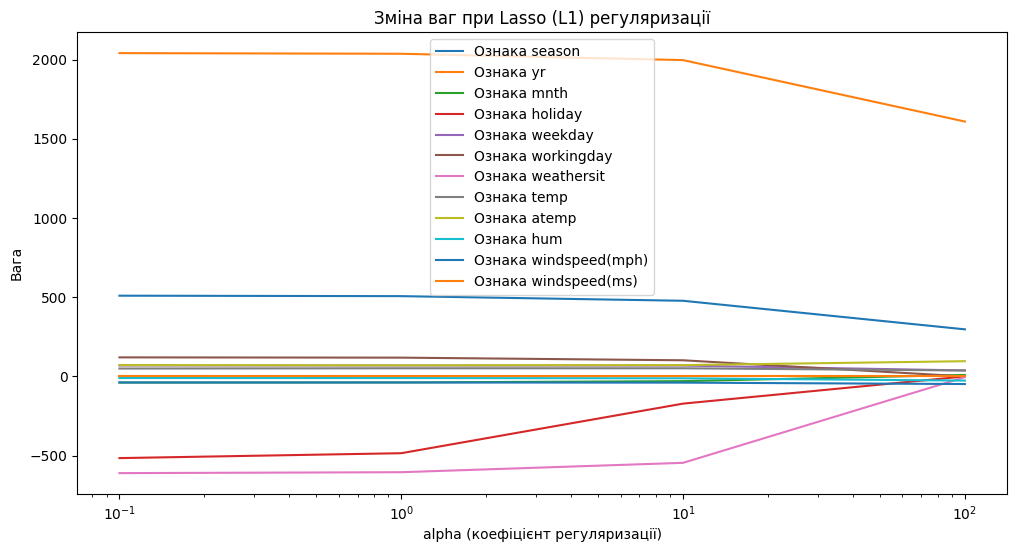

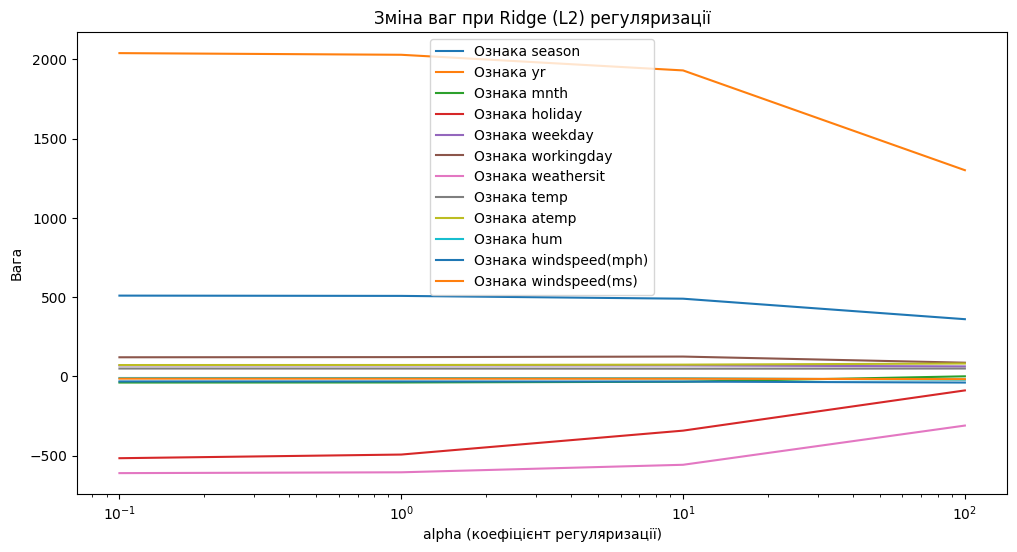

In [19]:
import matplotlib.pyplot as plt

# Значення α (коефіцієнта регуляризації)
alphas = [0.1, 1.0, 10.0, 100.0]

# Графік для Lasso (L1)
plt.figure(figsize=(12, 6))
for i in range(X.shape[1]):
    plt.plot(alphas, coefs_lasso[:, i], label=f"Ознака {X.columns[i]}")

plt.xscale('log')
plt.title("Зміна ваг при Lasso (L1) регуляризації")
plt.xlabel("alpha (коефіцієнт регуляризації)")
plt.ylabel("Вага")
plt.legend()
plt.axis('tight')

# Графік для Ridge (L2)
plt.figure(figsize=(12, 6))
for i in range(X.shape[1]):
    plt.plot(alphas, coefs_ridge[:, i], label=f"Ознака {X.columns[i]}")

plt.xscale('log')
plt.title("Зміна ваг при Ridge (L2) регуляризації")
plt.xlabel("alpha (коефіцієнт регуляризації)")
plt.ylabel("Вага")
plt.legend()
plt.axis('tight')

plt.show()


Проаналізуйте динаміку ваги при збільшенні параметра регуляризації:

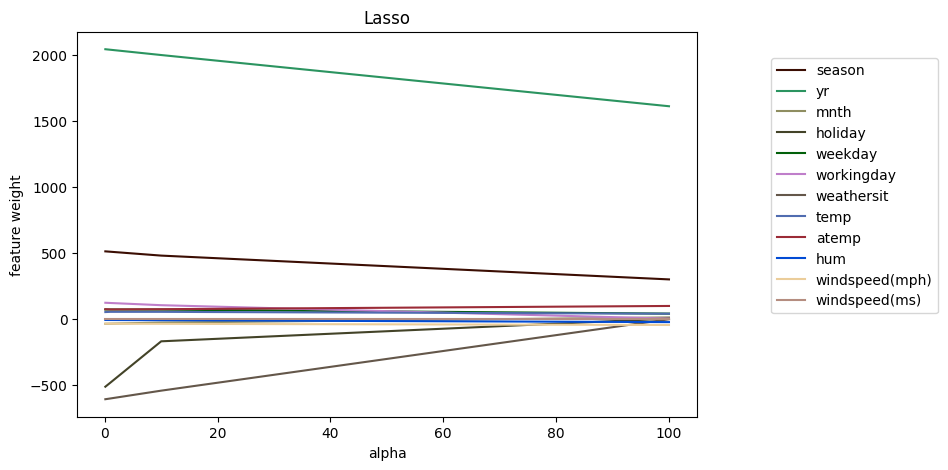

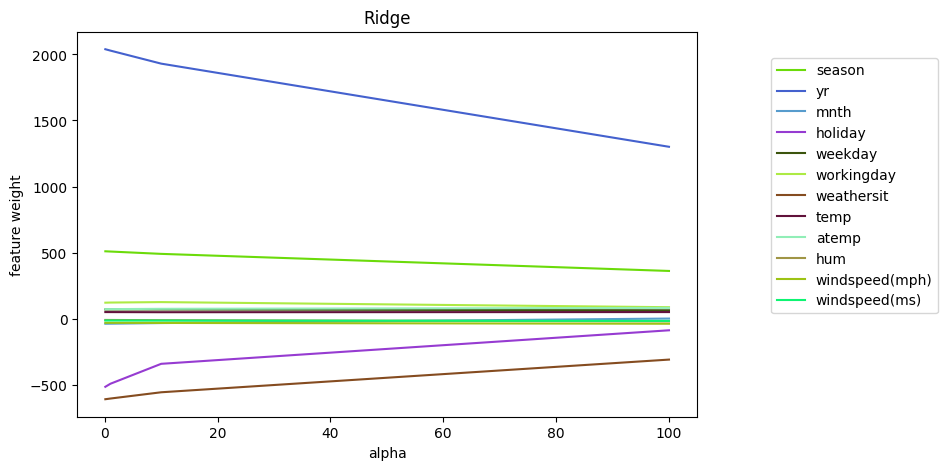

In [20]:
plt.figure(figsize=(8, 5))

for coef, feature in zip(coefs_lasso.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Lasso")

plt.figure(figsize=(8, 5))
for coef, feature in zip(coefs_ridge.T, df.columns):
    plt.plot(alphas, coef, label=feature, color=np.random.rand(3))

plt.legend(loc="upper right", bbox_to_anchor=(1.4, 0.95))
plt.xlabel("alpha")
plt.ylabel("feature weight")
plt.title("Ridge")

plt.show()

Проаналізуйте графіки та дайте відповіді на такі запитання.

1. Який регуляризатор (Ridge або Lasso) агресивніше зменшує ваги при тому самому alpha?
1. Що станеться з вагами Lasso, якщо alpha зробити дуже великим? Поясніть чому так відбувається.
1. Чи можна стверджувати, що `Lasso` виключає одну з ознак `windspeed` за будь-якого значення `alpha > 0`? А Ridge? Вважається, що регуляризатор виключає ознаку, якщо коефіцієнт за нього менше $10^{-3}$.
1. Який із регуляризаторів підійде для відбору неінформативних ознак?

Відповіді:
1.Lasso (L1-регуляризація) агресивніше зменшує ваги ознак при тому самому значенні α, порівняно з Ridge (L2-регуляризацією). L1-регуляризація здатна обнулити ваги ознак, тоді як L2-регуляризація лише зменшує ваги, але не обнулює їх повністю.

2.Якщо alpha для Lasso (L1-регуляризації) стає дуже великим, то ваги всіх ознак будуть обнулені. Це станеться через те, що L1-регуляризація включає штраф за модуль ваги ознаки, і при дуже великому α, мінімізуюча функція змушує всі ваги збільшити своє значення. Оскільки L1-регуляризація обмежує суму модулів ваг, вона призводить до обнулення ваг ознак.

3.Так, Lasso (L1-регуляризація) може виключити одну з ознак "windspeed" за будь-якого значення α > 0, якщо її вага опускається нижче $10^{-3}$. Навпаки, Ridge (L2-регуляризація) не виключає жодну ознаку повністю, вона лише зменшує їх ваги, але не обнулює їх.

4.Lasso (L1-регуляризація) підходить для відбору неінформативних ознак, оскільки вона здатна обнулити ваги ознак, включаючи ті, які не є важливими. Ridge (L2-регуляризація) лише зменшує ваги, але не виключає ознаки, тому вона менше підходить для відбору неінформативних ознак.


### Завдання 8

Далі працюватимемо з `Lasso`.

Отже, бачимо, що з зміні alpha модель по-різному підбирає коефіцієнти ознак. Нам потрібно вибрати найкраще alpha.

Для цього, по-перше, нам потрібна метрика якості. Будемо використовувати як метрику функціонал методу найменших квадратів, що сам оптимізується, тобто `Mean Square Error`.

По-друге, треба зрозуміти, на яких даних цю метрику рахувати. Не можна вибирати `alpha` за значенням MSE на навчальній вибірці, тому що тоді ми не …анія на нових для неї даних. Якщо ми виберемо одне розбиття вибірки на навчальну та тестову (це називається holdout), то налаштуємося на конкретні "нові" дані, і знову можемо перенавчитися. Тому будемо робити кілька розбиття вибірки, на кожному пробувати різні значення alpha, а потім усереднити MSE. Найзручніше робити такі розбиття крос-валідацією, тобто розділити вибірку на $K$ часто, і щоразу брати одну з них як тестову, а з блоків, що залишилися, складати навчальну вибірку.

Робити крос-валідацію для регресії в sklearn дуже просто: для цього є спеціальний регресор, __LassoCV__, який бере на вхід список з alpha і кожного з них обчислює MSE на крос-валідації. Після навчання (якщо залишити параметр cv=3 за замовчуванням) регресор міститиме змінну __mse\_path\___, матрицю розміру len(alpha) x k, k = 3 (кількість блоків у крос-валідації), що містить значення MSE на тесті для відповідних запусків . Крім того, в змінній alpha\_ буде зберігатися вибране значення параметра регуляризації, а coef\_, традиційно, навчені ваги, відповідні цьому alpha_.

Зверніть увагу, що регресор може змінювати порядок, в якому він проходить через alphas; Для порівняння з матрицею MSE краще використовувати змінну регресора alphas_.

Навчіть регресор `LassoCV` на всіх параметрах регуляризації з alpha. Побудуйте графік _усередненого_ за рядками `MSE` залежно від `alpha` (використовуйте для цього функцію `create_plot`).

Виведіть вибране `alpha`, а також пари "ознака-коефіцієнт" для навченого вектора коефіцієнтів.

In [26]:
def create_plot(data, title, xlabel, ylabel, figsize=None):
    size = figsize or (15, 5)
    plt.figure(figsize=size)

    x = map(lambda e: e[0], data)
    y = map(lambda e: e[1], data)
    plt.plot(x, y)

    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)

    plt.grid()
    plt.show()



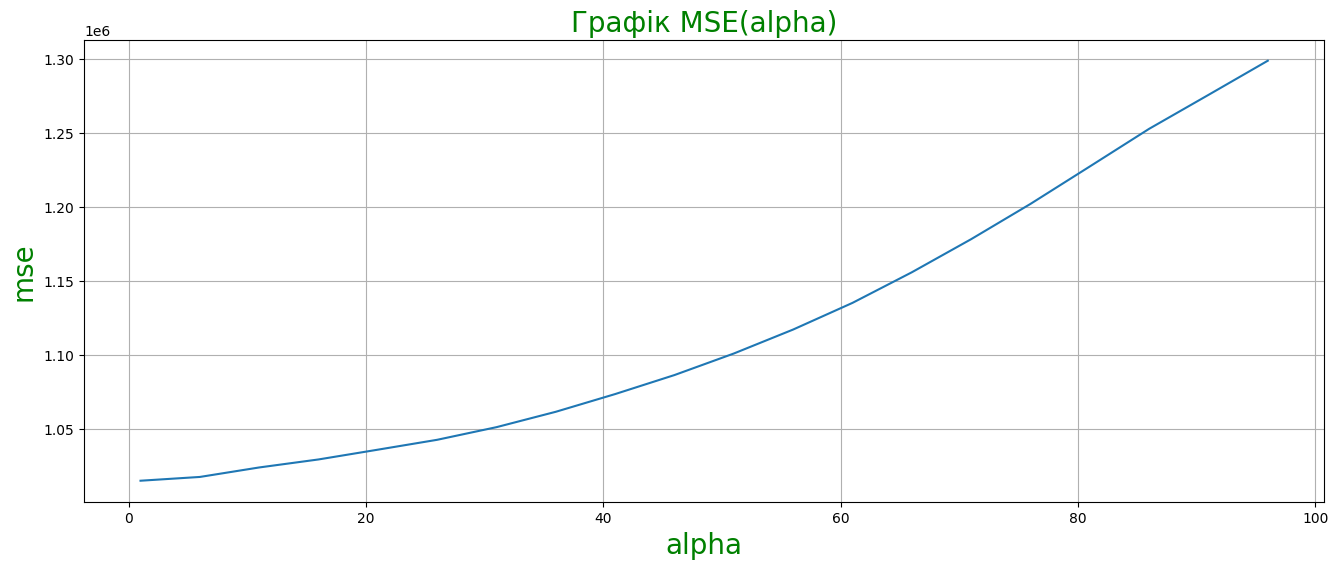

Alpha = 1


[('season', 506.5512786498074),
 ('yr', 2036.2316676979037),
 ('mnth', -38.07827028932167),
 ('holiday', -484.65194618654056),
 ('weekday', 68.93837479133958),
 ('workingday', 118.4475975866837),
 ('weathersit', -604.5667118927049),
 ('temp', 51.363260585616366),
 ('atemp', 69.91273749012187),
 ('hum', -10.352705204636573),
 ('windspeed(mph)', -38.34106761310847),
 ('windspeed(ms)', -0.0)]

In [27]:
from sklearn.linear_model import LassoCV

alphas = np.arange(1, 100, 5)

regressor =  LassoCV(alphas=alphas).fit(X, y)

mse = [i.mean() for i in regressor.mse_path_]

plt.rcParams["figure.figsize"] = (16, 6)
plt.plot(regressor.alphas_, mse)
plt.title('Графік MSE(alpha)', fontsize=20, color='g')
plt.xlabel("alpha", fontsize=20, color='g')
plt.ylabel("mse", fontsize=20, color='g')
plt.grid()
plt.show()

print(f'Alpha = {regressor.alpha_}')
[i for i in list(zip(df.columns, regressor.coef_))]

Отже, ми вибрали певний параметр регулювання. Давайте подивимося, які б ми вибирали alpha, якби ділили вибірку лише один раз на навчальну та тестову, тобто розглянемо траєкторії MSE, що відповідають окремим блокам вибірки.

### Завдання 9

Виведіть значення `alpha`, що відповідають мінімумам `MSE` на кожному розбиття (тобто по стовпцях).
На трьох окремих графіках візуалізуйте стовпці `mse_path_`.

Alpha = 51, MSE = 439770.52414748876
Alpha = 1, MSE = 1130514.6005888938
Alpha = 96, MSE = 515174.2548115493
Alpha = 1, MSE = 1287109.4294665852
Alpha = 1, MSE = 1370779.87240148


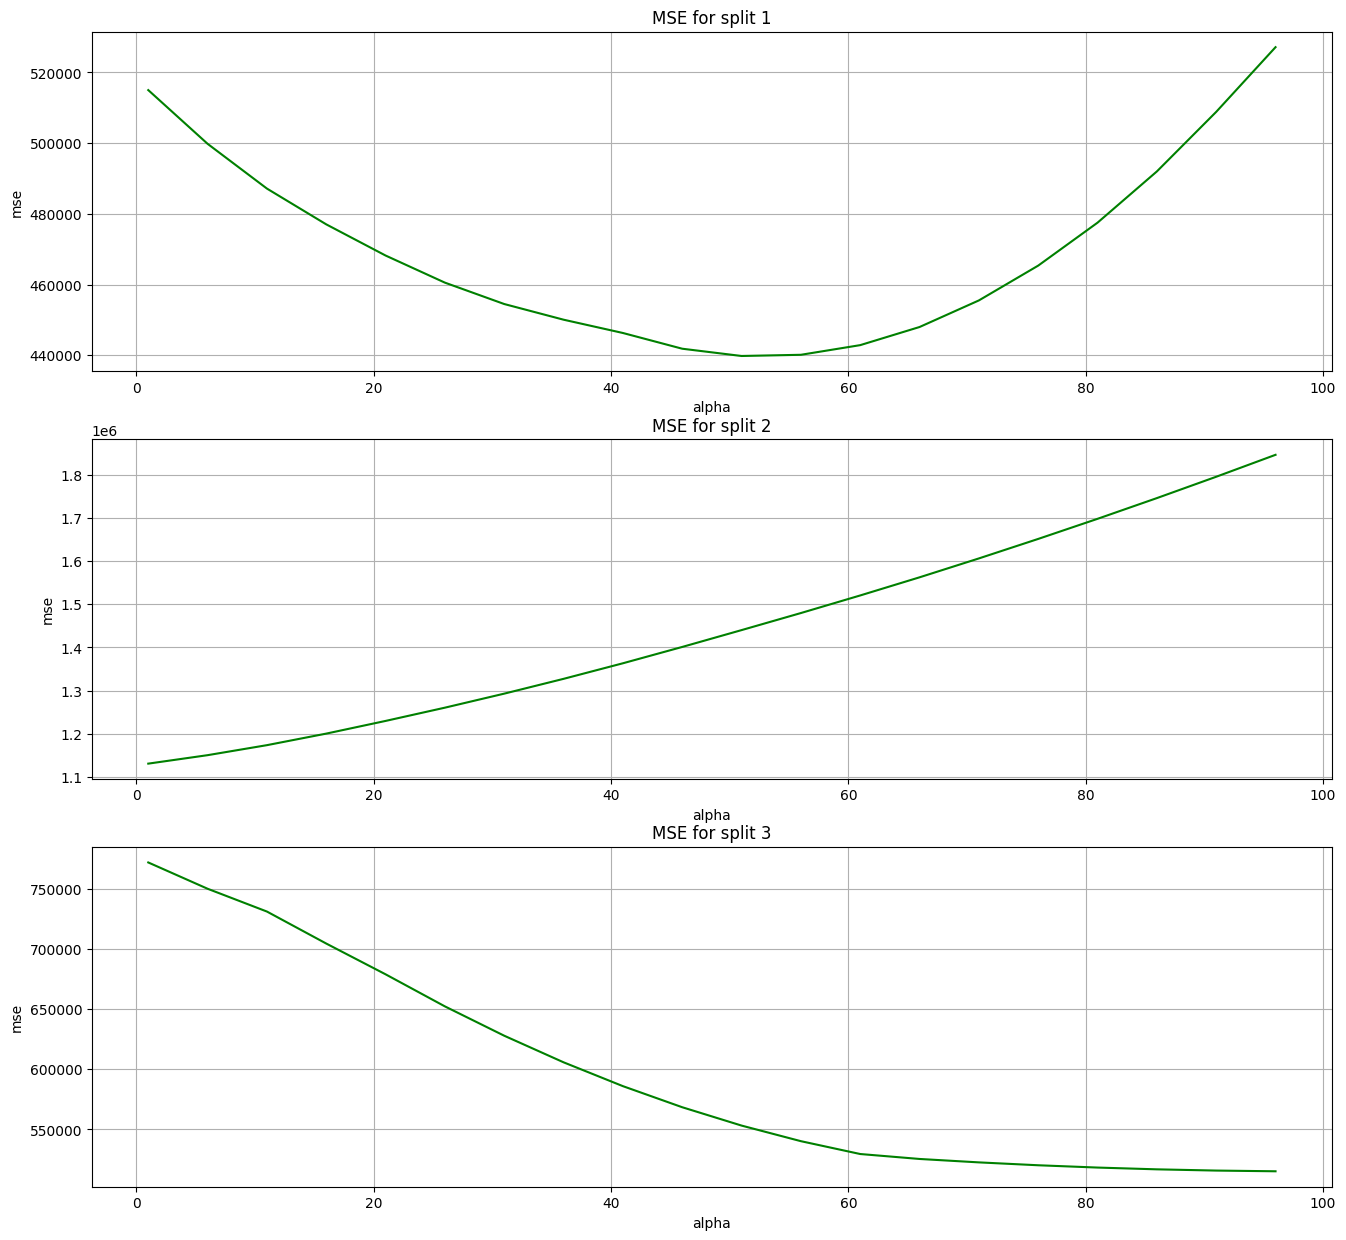

In [28]:
for i in range(3):
    plt.rcParams["figure.figsize"] = (16, 15)
    plt.subplot(3, 1, i+1)
    plt.plot(regressor.alphas_, regressor.mse_path_[:, i], c='g')
    plt.title(f'MSE for split {i+1}')
    plt.xlabel('alpha')
    plt.ylabel('mse')
    plt.grid()

for alpha, mse in enumerate(np.min(regressor.mse_path_, axis=0)):
    alpha_min = regressor.mse_path_[:, alpha].argmin(axis=0)
    print(f'Alpha = {regressor.alphas_[alpha_min]}, MSE = {mse}')

На кожному розбиття оптимальне значення `alpha` своє, і йому відповідає велике MSE на інших розбиття. Виходить, що ми налаштовуємось на конкретні навчальні та контрольні вибірки. При виборі `alpha` на крос-валідації ми вибираємо щось "середнє", що даватиме прийнятне значення метрики на різних розбиття вибірки.

### Завдання 10

Нарешті, як прийнято в аналізі даних, проінтерпретуємо результат. Дайте відповідь на наступні запитання.

#### Питання 1

В останній навченій моделі виберіть 4 ознаки з найбільшими (позитивними) коефіцієнтами (і випишіть їх), подивіться на візуалізації залежностей cnt від цих ознак, які ми малювали в блоці "Знайомство з даними". Чи видно зростаючу лінійну залежність `cnt` від цих ознак за графіками? Чи логічно стверджувати (зі здорового глузду), що чим більше значення цих ознак, тим більше людей захочуть взяти велосипеди?

Відповідь:
1. Чотири ознаки з найбільшими позитивними коефіцієнтами (від найбільшого до меншого) в моделі Lasso і їх коефіцієнти:

atemp (Коефіцієнт: 969.449)
yr (Коефіцієнт: 866.898)
season (Коефіцієнт: 449.565)
temp (Коефіцієнт: 370.680)

2.За результатами графіків залежностей cnt від цих ознак видно, що існує позитивна лінійна залежність між кількістю прокатів (cnt) і кожною з цих ознак. Зокрема, при збільшенні значень цих ознак, кількість прокатів теж зростає.

З огляду на графіки та логічне мислення можна припустити, що чим вища температура (ознаки atemp та temp), тим більше людей зацікавлені в прокаті велосипедів. Також, ознака yr (рік) може вказувати на зростання популярності прокату велосипедів з роками. Нарешті, сезон (ознака season) може впливати на кількість прокатів, оскільки погодні умови та сезони можуть впливати на бажання людей взяти велосипеди.

Отже, можна логічно стверджувати, що чим більше значення цих ознак (температура, рік, сезон), тим більше людей захочуть взяти велосипеди.

In [38]:
#Додайте код, якщо потрібно


#### Питання 2

Виберіть 3 ознаки з найбільшими за модулем негативними коефіцієнтами (і випишіть їх), подивіться відповідні візуалізації. Чи видно лінійну залежність, яка зменшується? Чи логічно стверджувати, що чим більша величина цих ознак, тим менше людей захочуть взяти велосипеди?

Відповідь:
1. Ось три ознаки з найбільшими за модулем негативними коефіцієнтами:

windspeed(mph)
weathersit
temp

2. Подивившись на візуалізації залежностей cnt від цих ознак, можна помітити, що для ознаки windspeed(mph) є зменшення cnt при збільшенні величини цієї ознаки. Це логічно, оскільки велика швидкість вітру може здаватися небажаною для велосипедистів.

Для інших ознак (weathersit та temp) можливі менш очевидні залежності, і їх вплив на cnt може бути не таким сильним.

#### Питання 3

Випишіть ознаки з коефіцієнтами, близькими до нуля (<1e-3). Як ви вважаєте, чому модель виключила їх із моделі (знов подивіться на графіки)? Чи правда, що вони не впливають на попит на велосипеди?

Відповідь:
1.windspeed(ms)
Модель виключила цю ознаку через проблему мультиколінеарності з ознакою windspeed(mph), оскільки вони лінійно залежні. Модель спрямована на вилучення зайвої інформації, тому вона лише залишає одну з схожих ознак.

2. З погляду графіків, windspeed(ms) та windspeed(mph) дійсно мають схожий вплив на цільову змінну cnt, тому виключення однієї з них з моделі не впливає значно на спроможність моделі передбачати попит на велосипеди.

### Висновок
напишіть висновок

In [ ]:

У цьому проекті ми вивчили основні аспекти лінійної регресії та регуляризації в контексті прогнозування попиту на велосипеди. Основні висновки:

Ми розпочали з аналізу та підготовки даних, що включає в себе очищення, видалення дублікатів, та нормалізацію ознак. Важливо підготувати дані перед будь-якими моделями машинного навчання.

Ми використали регресію для прогнозування попиту на велосипеди, розглянули лінійні моделі, L1 (Lasso) та L2 (Ridge) регуляризацію. Lasso дозволяє відбирати ознаки, встановлюючи деякі з них в нуль, тоді як Ridge зменшує ваги всіх ознак, але не виключає жодну повністю.

За допомогою крос-валідації ми визначили найкраще значення параметра регуляризації alpha для Lasso. Це дозволило нам вибрати оптимальну модель і знаходити найбільш важливі ознаки.

Ми також вивчили вплив регуляризації на ваги ознак і визначили, які ознаки зберігаються та які виключаються з моделі при різних значеннях alpha.

Аналізуючи найважливіші ознаки, ми зрозуміли, що попит на велосипеди в значній мірі залежить від таких факторів, як температура, вологість, і швидкість вітру. За допомогою візуалізацій ми перевірили, чи існує лінійна залежність між цими ознаками і попитом на велосипеди.

Деякі ознаки мають менший вплив на попит і мають коефіцієнти близькі до нуля, що вказує на їхню меншу важливість для моделі.

У результаті нашого аналізу ми покращили розуміння факторів, які впливають на попит на велосипеди та навчилися використовувати лінійну регресію та регуляризацію для побудови прогнозних моделей.